In this tutorial, we'll walk through running a neural network on genome data.

This part won't be very iPython tutorial-ly...

First cd in the terminal over to the data directory and have a look to our data.

In [1]:
!cd ../bonnie; ls;

humanvsran	  learnseq.ipynb  rollin-wild-giraffe-klonblog.jpg
humanvsran_label  predict_seq.py


Here you will find four files:<br><font color="#417EAE">humanvsran</font>: contain human 10,000 human sequences and 10,000 random sequences generated by RSAT random-seq.<br><font color="#417EAE">humanvsran_label</font>: labels for <font color="#417EAE">humanvsran</font>, where 1 stands for human sequences and 0 stands for random sequences.<br><font color="#417EAE">predict_seq.py</font>: python code for our CNN.<br><font color="#417EAE">learnseq.ipynb</font>: that's me!



Now lets have a look to our data!

In [7]:
!head ../bonnie/humanvsran -n 3

CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCAGAGGTTGCAGTGAGCCAAGATCGCACCACTGCACTCCAGCCTGGCAACACAGCGAGAGTCTGTCTCCAAAAAAAAAAAAAAAGGCCCAAGAGCATTTCAAACTGTTTGTTGAGAGGTAATCTTATACATTCAGTTTCTTTTGGCTTACCTGAAGAGGTGCTTGGCTATGGTTAACAAACTACGTAAGCTGGTGAAAAAACCTGT
CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACAACTAAGCCAAGACATGTTAAAAAAAAAGTTTGAAAAGAAAGCTGTAAGGAAATACAAGGGGAGGGATTGTTAGATATGAGTTCTAAATTTCTTTTCAAAAAATCGATATGTCAGTATGTTCAATTCTTTGCCTTCTACTTTTAAACTTCCTCATAAAGCAACCTTTTTCAATTACCTGCTCCACCCTGACTCATTCTGATCACC
AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGCTCACTCCTGTAATCCCAGCACTTTGGGAGGCCGAGGCTGGCGGATCACCTGAGGTCGGGAGTTCGAGACCAGCCTGACCAACATGGAGAACCCCTGTCTCTACTAAAATTACAAAATTAGCCAGGCATGGTGGCACATGTCTGTAATCCCAGCTACTTGGGAGGCTGAGGCAGGAGGATCATTTGAACCAGGGAGGCAGAGGTT


These are sequences randomly cut from human chromosome 1. Now have a look to the label file also.

In [9]:
!head ../bonnie/humanvsran_label -n3

0
0
0


All 1s since they are all human sequence, so if you 'tail' the file, it will be all zeros!

Now lets begin to train our predict_seq program! First import some libraries.

In [1]:
import numpy as np
import os
import tensorflow as tf
import sys
import re
import random
#========================= Model ==============================================
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Using TensorFlow backend.


Read our sequence and label file.

In [2]:
##Read data
f = open('../bonnie/humanvsran_label', "r")
lines = f.readlines()
f.close()
dat_y = np.zeros((len(lines),2))
for i in range(len(lines)):
	#dat_y[i] = float(dat_y[i].rstrip())
	dat_y[i,int(lines[i].rstrip())] = 1

f = open('../bonnie/humanvsran', "r")
lines = f.readlines()
f.close()

#Convert sequences into one-hot matrix
def DNA_matrix(seq):
	tem2 = ['[aA]','[cC]','[gG]','[tT]']
	for i in range(len(tem2)):
		ind = [m.start() for m in re.finditer(tem2[i], seq)]
		tem = np.zeros(len(seq),dtype=np.int)
		tem[ind] = 1
		if i==0:
			a = np.zeros((len(seq),4))
		a[...,i] = tem
	return a

for i in range(len(lines)):
	tem = lines[i].rstrip()
	if i==0:
		dat_x = np.zeros((len(lines),len(tem),4))
	dat_x[i,] = DNA_matrix(tem)


ind = range(20000)
random.shuffle(ind)
x_train=dat_x[ind[0:12000]]
y_train=dat_y[ind[0:12000]]
x_val=dat_x[ind[12001:14001]]
y_val=dat_y[ind[12001:14001]]
x_test=dat_x[14001:20001]
y_test=dat_y[14001:20001]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')


And you're good to go! Start training!

In [3]:
model=Sequential()
model.add(Conv1D(filters=20,kernel_size=10,strides=1,padding='valid',input_shape=(250,4), activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=5, padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
history = model.fit(x_train, y_train, batch_size=16, epochs=3, verbose=1, validation_data= None,callbacks=[early_stopping])
print(history.history)

Epoch 1/3
12000/12000 [==============================] - 6s - loss: 0.2124 - acc: 0.9053     
Epoch 2/3
12000/12000 [==============================] - 5s - loss: 0.0519 - acc: 0.9837     
Epoch 3/3
12000/12000 [==============================] - 5s - loss: 0.0308 - acc: 0.9900     
{'acc': [0.90533333333333332, 0.98366666666666669, 0.98999999999999999], 'loss': [0.21241368623139958, 0.051945729492154591, 0.030796271338379786]}


Next, evaluate our model

In [4]:
y_score = model.predict(x_test)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Testing loss: 0.0413593569079, acc: 0.988164694116



We can retrive and examine the weight matrix, and convert it into a PWM matrix.

In [5]:
weights = model.layers[0].get_weights()
wt=(np.transpose(weights[0][:,:,0]))
wtm=np.transpose(weights[0][:,:,0]).min(axis=0)
wtp=wt-wtm
wtps=np.sum(wtp, axis=0)
print np.round((wtp/wtps)*100)

[[ 54.  31.  31.  35.  43.  16.  39.   0.  23.   7.]
 [ 18.   0.   0.  59.   0.   0.   0.  44.  31.  28.]
 [  0.  23.  35.   6.  10.  55.  13.  21.   0.   0.]
 [ 28.  45.  34.   0.  47.  29.  48.  34.  46.  65.]]


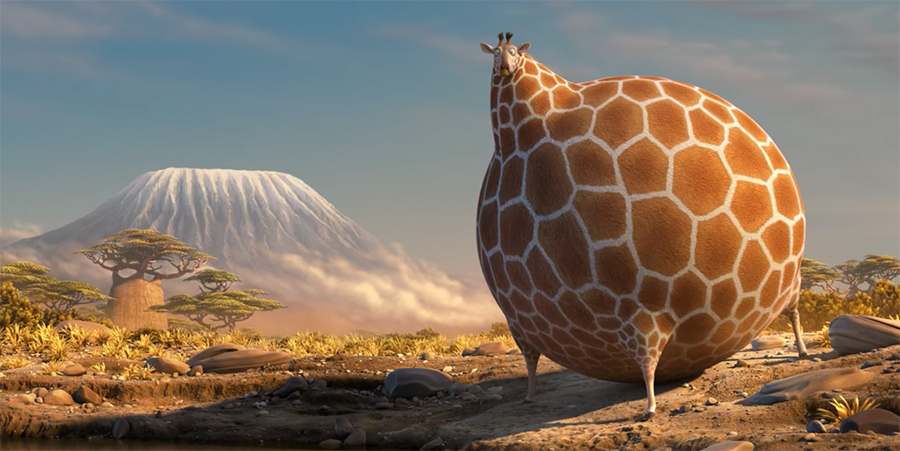

In [7]:
from IPython.display import Image
Image(filename='../bonnie/rollin-wild-giraffe-klonblog.jpg')